On commence par importer les bibliothèques qui vont être nécessaires.

In [55]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

In [56]:
!pip install ucimlrepo

In [57]:
from ucimlrepo import fetch_ucirepo #D'où on prend nos données

# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 
# get features and target
# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 
data = pd.concat([X, y], axis=1)
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [58]:
data.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,44923,45211,43354,45211,45211.000000,45211,45211,32191,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,8252,45211
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,4901,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


On peut commencer par voir qu'au niveau du 'count' (le nombre d'occurrences non vide), les nombres ne sont pas égaux entre les différentes colonnes, ce qui signifie qu'on va devoir réaliser un travail de nettoyage dessus, tout en estimant si l'on doit supprimer ou transformer la ligne ayant une 'donnée vide'.

Comme attendu, pour toutes les variables catégoriels (str) on ne peut pas calculer la moyenne, std ou autre.
On peut voir que le profil (à l'aide des features qui reviennent le +) type, est un ouvrier (blue collar) marié et ayant été en études secondaires (etc..) : il serait intéressant de vérifier si le dataset est bien équilibré pour ne pas avoir de biais dans l'analyse.

Les études sont classées en trois catégories.
On peut voir aussi des variables qui devraient sûrement nous être utiles : le fait d'avoir fait défaut déjà ou non, et le montant sur le compte bancaire (balance). De même, 'housing' et 'loan' devraient être pertinents.
Néanmoins, 'contact', 'day_of_the_week', 'month' paraissent peu pertinents pour le moment, même s'ils pourront mener à une analyse temporelle.

*duration* : Durée du dernier contact téléphonique avec le client (en secondes).

*campaign* : Nombre de contacts réalisés avec ce client lors de cette campagne marketing.

*pdays* : Nombre de jours écoulés depuis que le client a été contacté lors d’une campagne précédente.
avec pdays = -1 signifie jamais contacté auparavant.

*previous* : Nombre de contacts réalisés dans toutes les campagnes précédentes.

*poutcome* : Résultat de la dernière campagne marketing : "success", "failure" ou "nonexistent" → le client n’a jamais été contacté avant

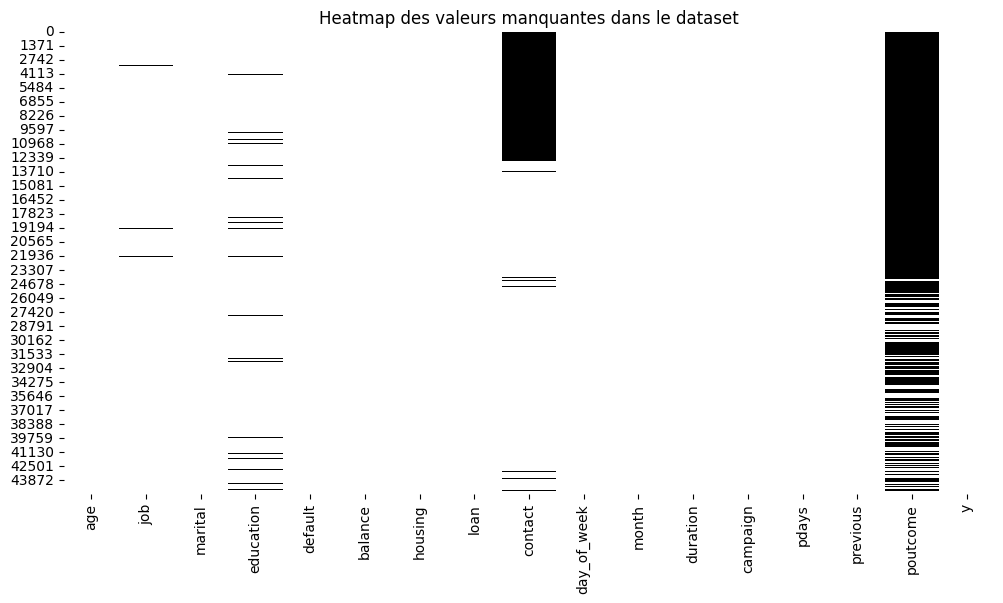

In [59]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), 
            cbar=False, 
            cmap='Greys')
plt.title("Heatmap des valeurs manquantes dans le dataset")
plt.show()


On voit que là où on manque le + de valeurs est dans *contact* où on semble manquer au moins 25% de valeurs et dans *poutcome* où il manque >95% de valeurs.

Pour *contact* cela ne devrait pas nous poser véritablement de problèmes car on peut faire l'hypothèse plutôt vraisemblable que le moyen de contacter n'a que très peu d'influences sur le résultat (on va vérifier ceci juste après).

Pour *poutcome* cela est assez étrange, peut-être que la variable est mal 'annotée', et met les clients qui n'ont jamais été contacté auparavant comme inexistant (malgré la présence de 3 catégories). Il va falloir regarder ceci de plus près.

Le dernier pour lequel il manque un peu de valeurs (mais pas substantiellement) est la variable *education* : on va regarder ce que cela représente en %.

In [60]:
#On fait le choix de remplacer toutes les valeurs manquantes des colonnes peu vides par la catégorie qui tombe le +
#C'est un choix arbitraire que l'on pourrait éventuellement rediscuter (par exemple dans les valeurs manquantes répartir selon la répartition de l'échantillon)
data['job'] = data['job'].fillna(data['job'].mode().iloc[0])
data['education'] = data['education'].fillna(data['education'].mode().iloc[0])
data['balance'] = data['balance'].fillna(data['balance'].mode().iloc[0])
data['marital'] = data['marital'].fillna(data['marital'].mode().iloc[0])
data['default'] = data['default'].fillna(data['default'].mode().iloc[0])
data['housing'] = data['housing'].fillna(data['housing'].mode().iloc[0])
data['loan'] = data['loan'].fillna(data['loan'].mode().iloc[0])

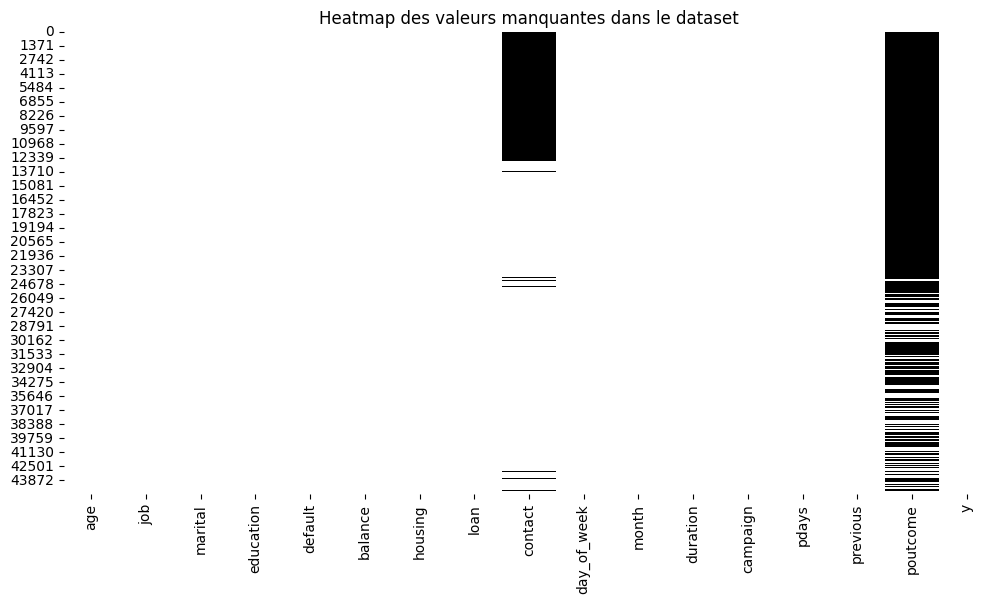

In [61]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), 
            cbar=False, 
            cmap='Greys')
plt.title("Heatmap des valeurs manquantes dans le dataset")
plt.show()


In [62]:
data['contact'].value_counts(normalize=True)

contact
cellular     0.909726
telephone    0.090274
Name: proportion, dtype: float64

<Figure size 800x500 with 0 Axes>

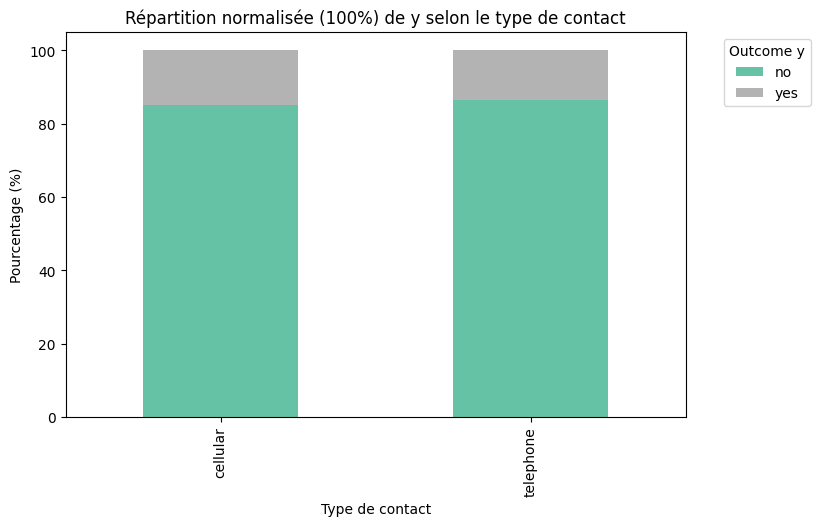

In [63]:
table = data.groupby(['contact','y']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1) 
#D'abord on compte combien de lien pour chaque possibilité
#Ensuite avec le unstack on fait la transposée de notre tableau', pour pouvoir afficher le graphique après
#Le .apply est juste ici pour normaliser les valeurs.
plt.figure(figsize=(8,5))
table.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8,5)) #Afficher la répartition et non le comptage

plt.title("Répartition normalisée (100%) de y selon le type de contact")
plt.ylabel("Pourcentage (%)")
plt.xlabel("Type de contact")
plt.legend(title="Outcome y", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

On voit donc bien que malgré le déséquilibre total dans l'échantillon entre 'cellular' et 'telephone', la répartition de oui et de non semble la même entre cellular et telephone, ce qui nous donne un premier indice sur son apport au modèle.

In [64]:
import statsmodels.formula.api as smf

# Encoder y en numérique dans le dataframe (obligatoire pour la formule)
df = data.copy()
df['y'] = df['y'].replace({'yes': 1, 'no': 0}).astype(float) #sinon on peut pas faire de régression

# Régression OLS avec formule automatique, dans l'autre cas ça plantait
model = smf.ols(
    formula = "y ~ age + balance + day_of_week + duration + campaign + pdays + previous + contact + month + job + marital + education + default + housing + loan + poutcome",
    data = df
).fit()

print(model.summary())


/tmp/ipykernel_1837/2841003652.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0}).astype(float) #sinon on peut pas faire de régression


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     130.6
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        15:14:26   Log-Likelihood:                -2594.7
No. Observations:                8182   AIC:                             5267.
Df Residuals:                    8143   BIC:                             5541.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

Ceci nous permet de voir qu'en isolant l'effet de toutes les autres variables : même s'il semblait que la proportion cellular/telephone parmi les y=yes or no était presque la même, dans les faits, au seuil de 5% on peut rejeter l'hypothèse que le coefficient lié à la variable *contact* soit nul (donc sans effet sur y), autrement dit : ce coefficient est significatif (au seuil de 5%).
On devra donc trouver un autre moyen de palier l'absence de réponses.

FAIRE UN XGBOOST POUR DONNER DES VALEURS à CONTACT AVANT DE DONNER DES VALEURS à POUTCOME

In [65]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

df2 = data.copy()

# 1. Define wanted features WITHOUT 'contact'
wanted = [
    "age","balance","day_of_week","duration","campaign","pdays","previous",
    "month","job","marital","education","default","housing","loan",
    "poutcome"
]

features = [c for c in df2.columns if c in wanted]

# 2. Split train / pred
df_train = df2.dropna(subset=['contact']).copy()
df_pred  = df2[df2['contact'].isna()].copy()

# 3. Encode target BEFORE any factorization
le = LabelEncoder()
df_train['contact_num'] = le.fit_transform(df_train['contact'])

# 4. Factorize ONLY the feature columns (never the target, never 'contact')
cat_cols = df_train[features].select_dtypes(include=['object','category']).columns

for c in cat_cols:
    df_train[c], uniques = pd.factorize(df_train[c])
    df_pred[c] = df_pred[c].map({u:i for i,u in enumerate(uniques)}).fillna(-1).astype(int)

# 5. XGBoost
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(df_train[features], df_train['contact_num'])

# 6. Predict missing contact
pred_num = model.predict(df_pred[features])
pred_label = le.inverse_transform(pred_num)

df_pred['contact_pred'] = pred_label

# 7. Keep original contact when known
df_train['contact_pred'] = df_train['contact']

# 8. Merge
df_final = pd.concat([df_train, df_pred]).sort_index()


In [66]:
data = data.rename(columns={"contact": "contact_filled"})
data["contact_filled"]=df_final["contact_pred"]

In [67]:
data.describe(include="all")

,age,job,marital,education,default,balance,housing,loan,contact_filled,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,8252,45211
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure,no
freq,NaN,10020,27214,25059,44396,NaN,25130,37967,42142,NaN,13766,NaN,NaN,NaN,NaN,4901,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


On voit que les seuls valeurs manquantes concernent désormais uniquement *poutcome*

In [68]:
data['poutcome'].value_counts()

poutcome
failure    4901
other      1840
success    1511
Name: count, dtype: int64

Ici on est obligé de tenter de palier cela :
1) On peut supprimer les lignes manquantes (cela représente 95% du dataset)
2) Transformer à l'aide d'une moyenne l'échantillon (donner la valeur moyenne pour les valeurs manquantes de telle sorte à ne pas biaiser celui-ci). Sauf qu'en faisant ceci, cela signifie qu'on va ajouter    (1511/4901)*ensemble valeurs manquantes en succès et donc garder les mêmes proportions. Mais ceci revient à faire une hypothèse un peu trop forte : celle de considérer qu'on a la même répartition de résidu dans ce 10% de valeurs qu'on a que dans l'ensemble du dataset (autrement dit, on fait une sorte d'hypothèse d'homoskedasticité). 
3) On va essayer de faire quelque chose qui nous semble peut-être moins risqué au premier abord, et explicatif : essayer de prédire la valeur de *poutcome* à l'aide des variables que l'on a déjà (sauf celles qui ne peuvent pas participer à jouer de manière causale sur *poutcome* à l'image de *y*, ou de *pdays*, *day_of_the_week*, *month*, *previous*, *campaign* et *duration* car celles-ci ne nous donne que les caractéristiques de la dernière campagne et non les caractéristiques 'intrasèques' de l'individu.

L'option 1) et 2) nous semblent peu pertinentes.

In [69]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

df3 = data.copy()

# 1. Define wanted features WITHOUT 'contact'
wanted2 = ["age","job","marital","education","default","balance","housing","loan","contact_filled"]
features2 = [c for c in df3.columns if c in wanted]

# 2. Split train / pred
df3_train = df3.dropna(subset=['poutcome']).copy()
df3_pred  = df3[df3['poutcome'].isna()].copy()

# 3. Encode target BEFORE any factorization
le = LabelEncoder()
df3_train['poutcome_num'] = le.fit_transform(df3_train['poutcome'])

# 4. Factorize ONLY the feature columns 
cat_cols = df3_train[features2].select_dtypes(include=['object','category']).columns

for c in cat_cols:
    df3_train[c], uniques = pd.factorize(df3_train[c])
    df3_pred[c] = df3_pred[c].map({u:i for i,u in enumerate(uniques)}).fillna(-1).astype(int)

# 5. XGBoost
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(df3_train[features2], df3_train['poutcome_num'])

# 6. Predict missing contact
pred2_num = model.predict(df3_pred[features2])
pred2_label = le.inverse_transform(pred2_num)

df3_pred['poutcome_pred'] = pred2_label

# 7. Keep original contact when known
df3_train['poutcome_pred'] = df3_train['poutcome']

# 8. Merge
df_final3 = pd.concat([df3_train, df3_pred]).sort_index()


In [70]:
data = data.rename(columns={"poutcome": "poutcome_filled"})
data["poutcome_filled"]=df_final3["poutcome_pred"]

In [71]:
data.describe(include="all")

,age,job,marital,education,default,balance,housing,loan,contact_filled,day_of_week,month,duration,campaign,pdays,previous,poutcome_filled,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure,no
freq,NaN,10020,27214,25059,44396,NaN,25130,37967,42142,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


In [72]:
import statsmodels.formula.api as smf
import numpy as np

df3 = data.copy()

# 1. Encoder Y
df3['poutcome_num'] = df3['poutcome'].map({
    'failure': 0,
    'other': 1,
    'success': 2
})

# 2. Sélectionner les données complètes pour Y
df3_train = df3.dropna(subset=['poutcome_num']).copy()

# 3. Imputation simple des NaN dans X
num_cols = df_train.select_dtypes(include=['float64','int64']).columns
df3_train[num_cols] = df3_train[num_cols].fillna(df_train[num_cols].mean())

cat_cols = df3_train.select_dtypes(include=['object']).columns
df3_train[cat_cols] = df3_train[cat_cols].fillna(df3_train[cat_cols].mode().iloc[0])

model = smf.mnlogit(
    formula="poutcome_num ~ age + balance + job + marital + education + default + housing + loan + contact",
    data=df3_train
).fit()

print(model.summary().as_text())


KeyError: 'poutcome'

In [ ]:
data.describe(include="all")

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y,poutcome_num_pred,poutcome_pred,poutcome_final
count,45211.000000,44923,45211,43354,45211,45211.000000,45211,45211,32191,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,31317,45211,30907.000000,30907,31317
unique,NaN,11,3,3,2,NaN,2,2,2,NaN,12,NaN,NaN,NaN,NaN,3,2,NaN,3,3
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,failure,no,NaN,failure,failure
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,26820,39922,NaN,29374,26820
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN,0.097486,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN,0.428672,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN,0.000000,NaN,NaN


Il semble que le day_of_week représente en fait le jour dans le mois puisqu'il commence le 1 et termine le 31. C'est un point qui peut-être intéressant car les comportements ne sont pas les mêmes en début et en fin de mois, en particulier lorsque cela concerne l'aspect financier.

In [ ]:
data = data.rename(columns={"day_of_week": "day_of_the_month"})

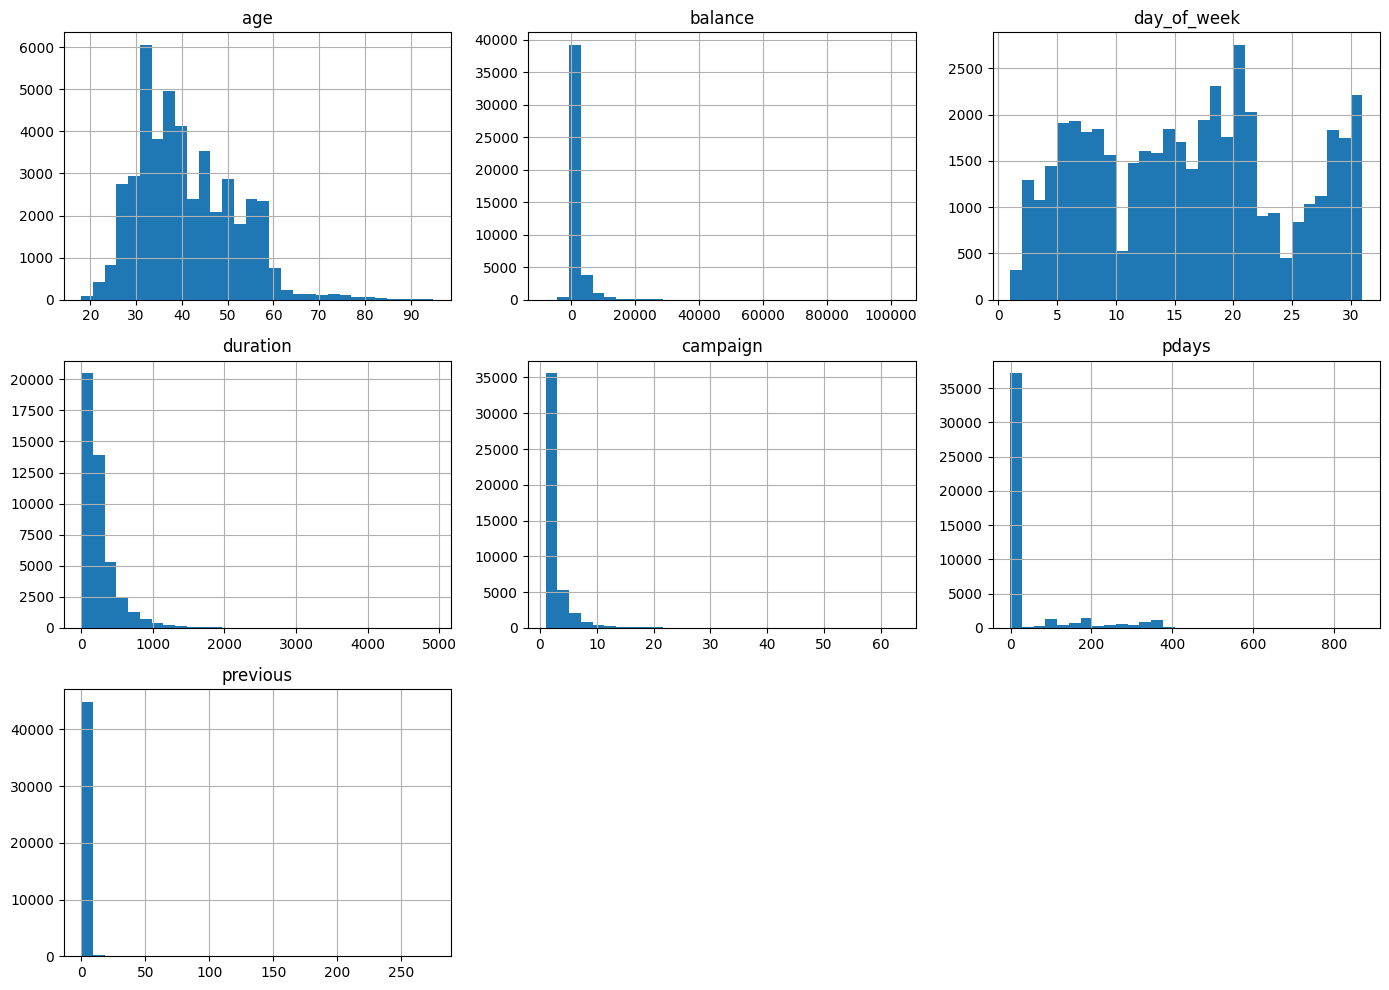

In [ ]:
data.hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

In [73]:
cols = ["duration", "previous", "campaign", "pdays", "balance"]

for c in cols:
    data[c] = data[c].replace(0, 1)

VERIFIE CECI ET BIEN TOUT NOTER POUR QUE CA SOIT CLAIR POUR LE READER

In [74]:
data["duration"]=np.log(data["duration"])
data["previous"]=np.log2(data["previous"])
data["campaign"]=np.log2(data["campaign"])
data["pdays"]=np.log2(data["pdays"])
data["balance"]=np.log(data["balance"])

/opt/python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/python/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


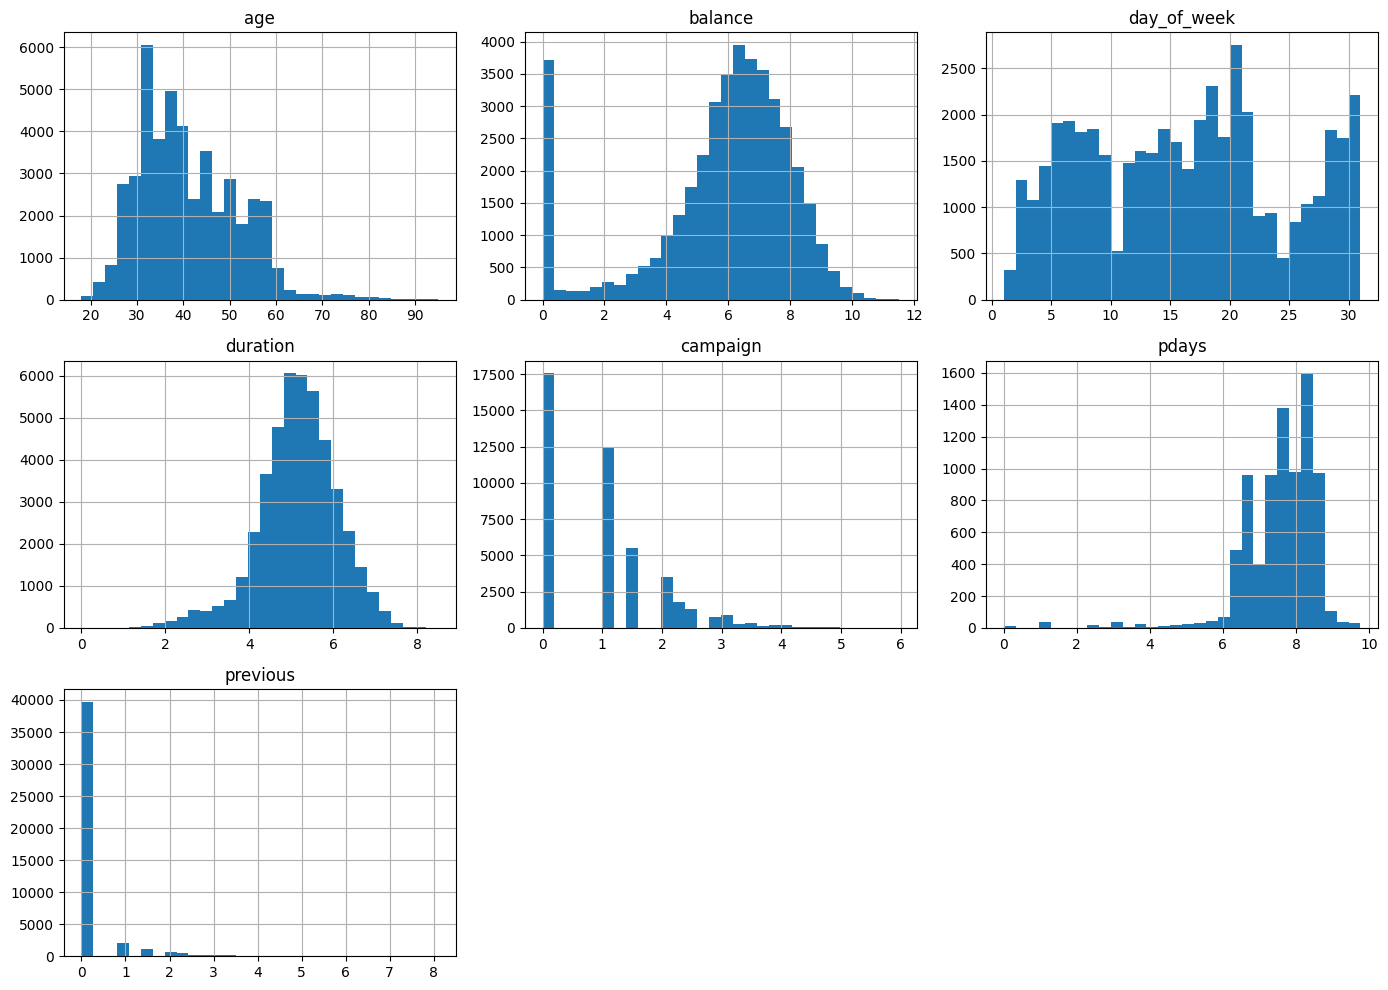

In [75]:
data.hist(figsize=(14, 10), bins=30)
plt.tight_layout()
plt.show()


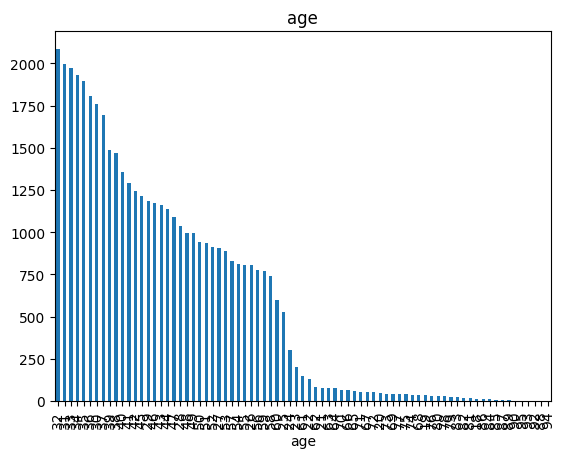

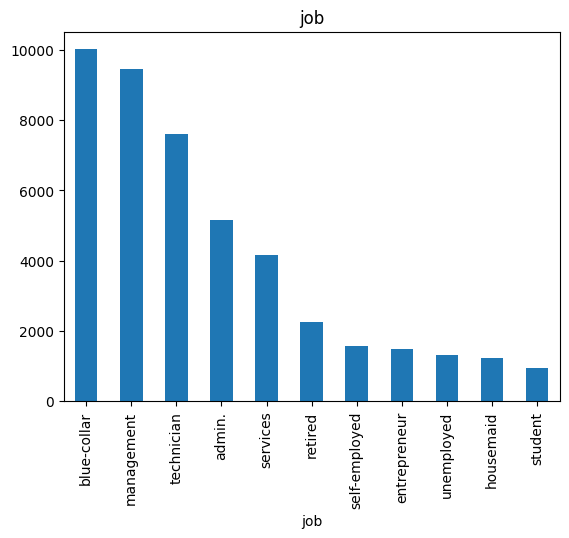

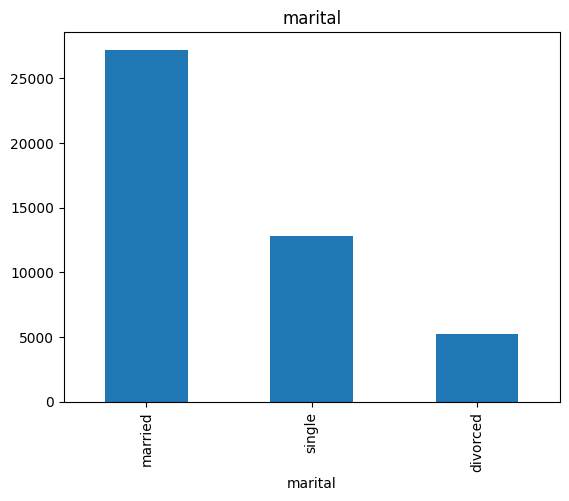

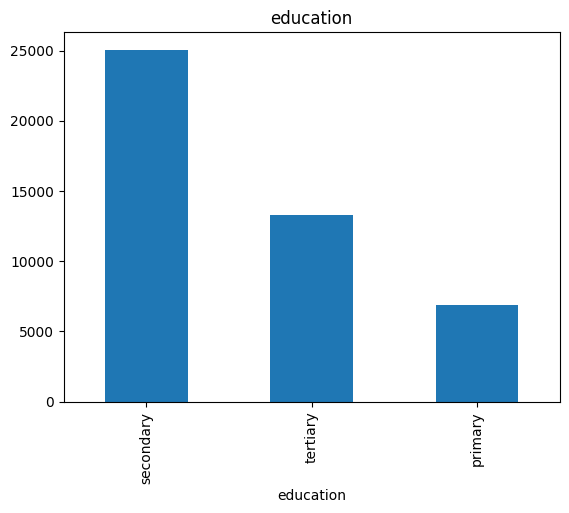

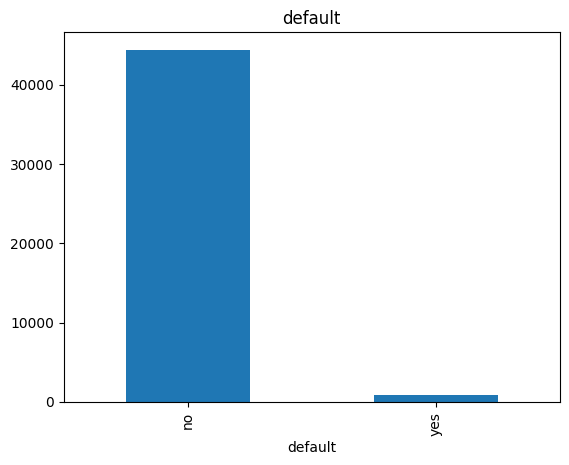

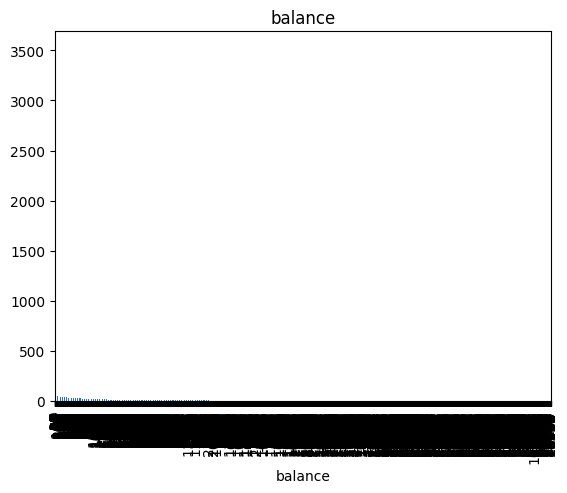

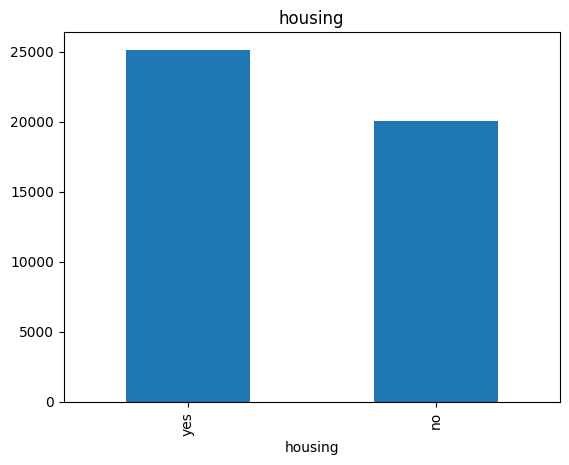

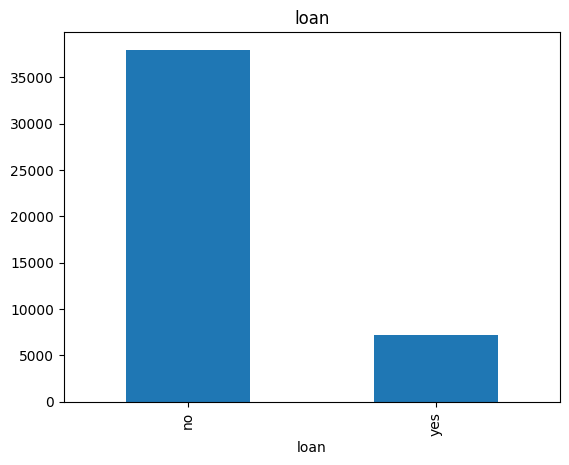

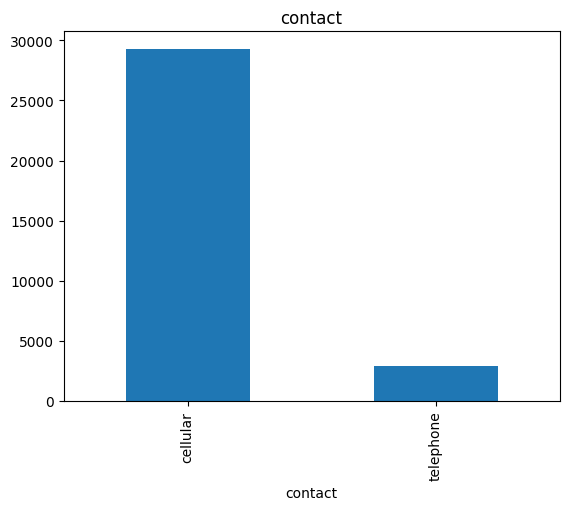

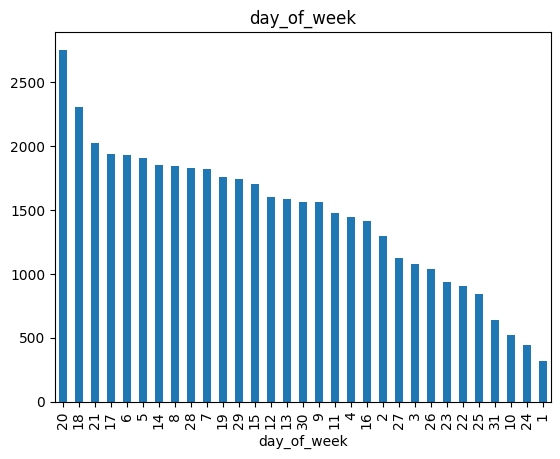

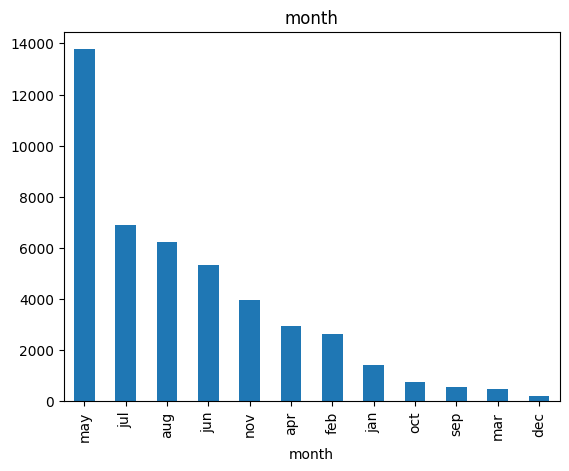

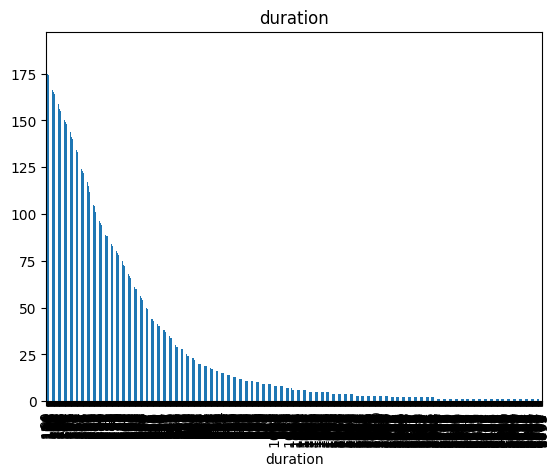

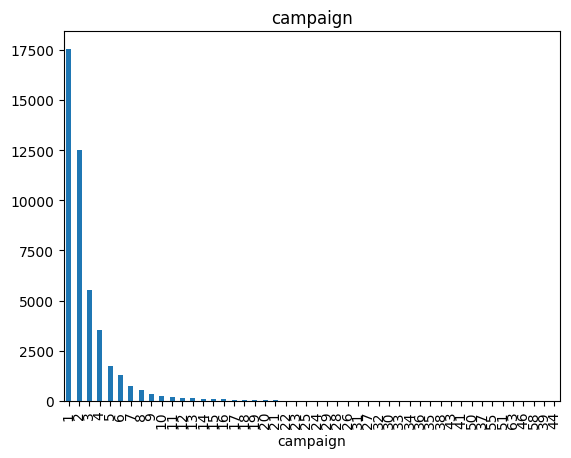

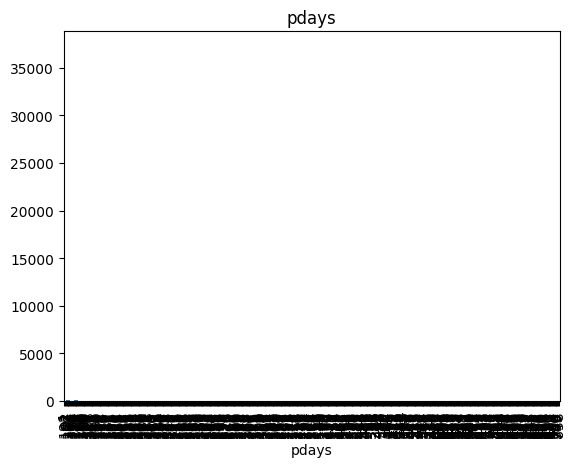

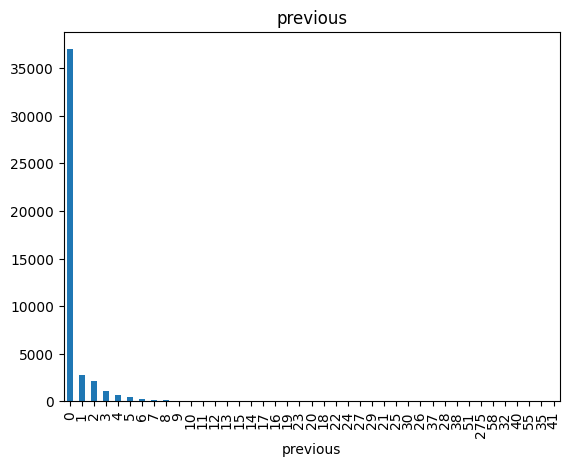

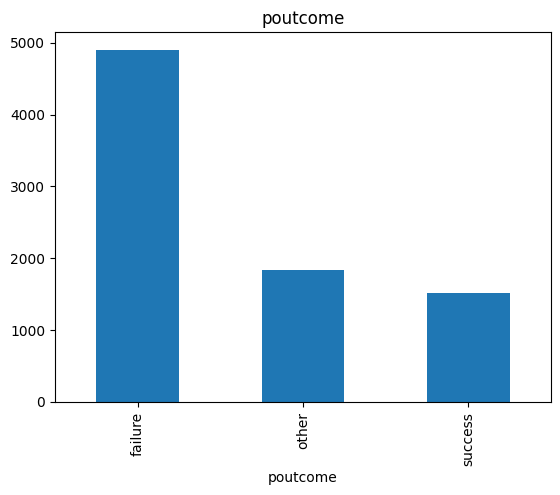

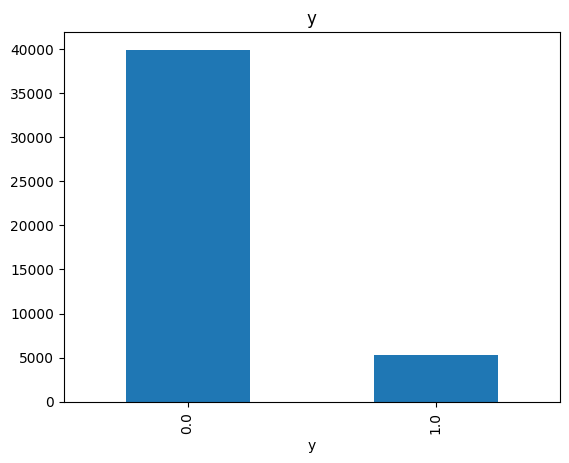

In [55]:
for col in df.columns:
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
